In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [5]:
# 3.2.1 生成数据集
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) # 加上噪音项
    return X, y.reshape((-1, 1))
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.9984, -1.6956]) 
label: tensor([7.9651])


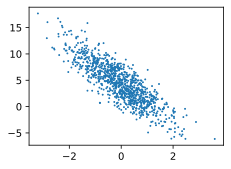

In [8]:
# 第二个特征features[:, 1]和labels的散点图
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [71]:
# 3.2.2 读取数据集
# 每次抽取一小批样本来对模型进行更新
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 样本随机读取，没有特定顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i+batch_size, num_examples)] # 防止样本个数不能被批量大小整除
            # min(i+batch_size, num_examples)
            # 不能被整除时，最后一批样本数量一定小于batch_size，即i+batch_size会超出范围
            # 此时索引只需要到最后一个样本处，即[i:num_examples]
            # 而其他批次，固定为[i: i+batch_size]
        )
        yield features[batch_indices], labels[batch_indices]

In [10]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.4259,  1.6099],
        [ 0.4839, -1.0735],
        [ 0.7151,  0.7329],
        [ 1.4292, -0.8816],
        [ 0.4404,  1.1616],
        [ 0.9762, -0.3908],
        [ 0.3671, -0.0581],
        [ 1.4436,  0.5787],
        [ 1.0734, -0.3831],
        [-0.3643, -0.2109]]) 
 tensor([[-0.4269],
        [ 8.8204],
        [ 3.1316],
        [10.0426],
        [ 1.1305],
        [ 7.4756],
        [ 5.1219],
        [ 5.1265],
        [ 7.6452],
        [ 4.1836]])


In [65]:
# 3.2.3 初始化模型参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [66]:
# 3.2.4 定义模型
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [67]:
# 3.2.5 定义损失函数
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [68]:
# 3.2.6 定义最优化算法
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            # -= 运算会执行原地操作，也就是运算结果会传递给同一块内存
            # 所以变化的就是全局变量了
            # 但是如果这里改成 param = param - ... 结果就不对了
            param.grad.zero_()

In [69]:
# 3.2.7 训练
lr = 0.01
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f"epoch {epoch+1}, loss {float(train_l.mean()):f}")

epoch 1, loss 2.089180
epoch 2, loss 0.250194
epoch 3, loss 0.030063
epoch 4, loss 0.003661
epoch 5, loss 0.000480
epoch 6, loss 0.000097
epoch 7, loss 0.000051
epoch 8, loss 0.000046
epoch 9, loss 0.000045
epoch 10, loss 0.000045


In [70]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0005, -0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)
